In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
# Recuperar el mismo DataFrame
with open('dfe_guardado.pkl', 'rb') as e:
    dfe = pickle.load(e)
dfa = dfe.copy()

In [3]:
dfa = dfa.drop(['goles_local', 'goles_visitante'], axis=1)

In [4]:
# Ver las primeras filas del dataset
print(dfa.head())

# Ver las columnas disponibles
print("Columnas del dataset:")
print(dfa.columns.tolist())


   torneo  semestre    ronda  fecha_torneo equipo_local equipo_visitante  \
0    2021         1  INICIAL             1  millonarios         envigado   
1    2021         1  INICIAL             1       junior         medellin   
2    2021         1  INICIAL             1        pasto          equidad   
3    2021         1  INICIAL             1     nacional         santa fe   
4    2021         1  INICIAL             1         cali         jaguares   

  resultado  
0     LOCAL  
1     LOCAL  
2    EMPATE  
3     LOCAL  
4     LOCAL  
Columnas del dataset:
['torneo', 'semestre', 'ronda', 'fecha_torneo', 'equipo_local', 'equipo_visitante', 'resultado']


In [5]:
# Columnas categóricas a codificar
label_cols = ['ronda', 'equipo_local', 'equipo_visitante']
le_dict = {}

for col in label_cols:
    le = LabelEncoder()
    dfa[col] = le.fit_transform(dfa[col])
    le_dict[col] = le  # Guardar para predicciones futuras


label_resultado = LabelEncoder()
dfa['resultado'] = label_resultado.fit_transform(dfa['resultado'])

In [6]:
# Separar datos y etiquetas
X = dfa.drop("resultado", axis=1)
y = dfa["resultado"]


In [7]:
# Pesos balanceados por clase, Le da mayor importancia a la clase con menos peso por ejemplo gana visitante y empate
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y),
                                     y=y)
class_weights_dict = dict(enumerate(class_weights))


In [8]:
# -----Validación Cruzada-----
kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)
accuracies = []
f1_scores = []


for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modelo pequeño para dataset pequeño
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(len(np.unique(y)), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=50, batch_size=4,
              validation_data=(X_test, y_test),
              class_weight=class_weights_dict,
              verbose=0, callbacks=[es])

    y_pred = np.argmax(model.predict(X_test), axis=1)

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 



-----RESULTADO VALIDACIÓN CRUZADA-----
--------------------------------
Accuracy Promedio: 0.4049
F1-score Promedio: 0.2376
Todos los Accuracies: [0.29958960328317374, 0.4582763337893297, 0.45690834473324216]


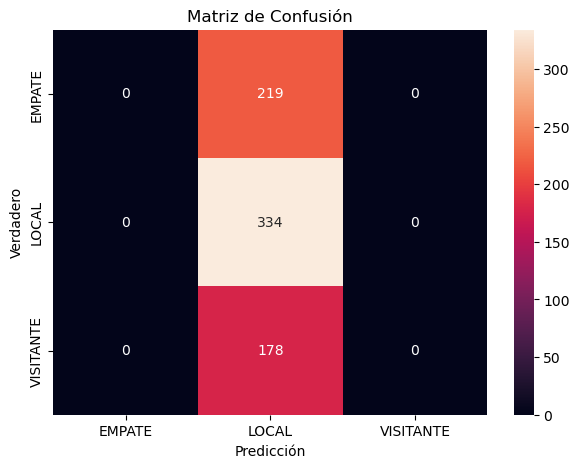

In [9]:
# === Resultados ===
print("\n-----RESULTADO VALIDACIÓN CRUZADA-----")
print("--------------------------------")
print(f"Accuracy Promedio: {np.mean(accuracies):.4f}")
print(f"F1-score Promedio: {np.mean(f1_scores):.4f}")
print(f"Todos los Accuracies: {accuracies}")

# === Matriz de Confusión final (último fold) ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_resultado.classes_,
            yticklabels=label_resultado.classes_)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [10]:
# Entrenar modelo final con todos los datos
model_final = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(len(np.unique(y)), activation='softmax')
])

model_final.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

model_final.fit(X, y, epochs=100, batch_size=4, verbose=1)


Epoch 1/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.3507 - loss: 76.9420 
Epoch 2/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3379 - loss: 7.6451 
Epoch 3/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4528 - loss: 1.4886
Epoch 4/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4523 - loss: 1.2010
Epoch 5/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4560 - loss: 1.1179
Epoch 6/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4560 - loss: 1.1129
Epoch 7/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4578 - loss: 1.1073
Epoch 8/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4578 - loss: 1.1040
Epoch 9/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4578 - loss: 1.1005
Epoch 10/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4578 - loss: 1.0969
Epoch 11/100
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4578 - loss: 1.0947
Epoch 12/100
549/549 ━━━━━━━━━━━━━━━━━

In [11]:
# Guardar en disco diccionario
joblib.dump(le_dict, "encoders.pkl")
joblib.dump(label_resultado, "resultado_encoder.pkl")

model.save("modelo_partidos.keras")

In [12]:
# Cargar modelo y encoders
modelo = load_model("modelo_partidos.keras")
le_dict = joblib.load("encoders.pkl")
label_resultado = joblib.load("resultado_encoder.pkl")

def predecir_resultado(torneo, semestre, ronda, fecha, local, visitante):

    try:
        ronda_code = le_dict['ronda'].transform([ronda])[0]
        local_code = le_dict['equipo_local'].transform([local.lower()])[0]
        visitante_code = le_dict['equipo_visitante'].transform([visitante.lower()])[0]
    except:
        return "--Error: Equipo o ronda no existe en el dataset de entrenamiento"

    entrada = pd.DataFrame([[torneo, semestre, ronda_code, fecha,
                             local_code, visitante_code]],
                           columns=["torneo", "semestre", "ronda",
                                    "fecha_torneo", "equipo_local",
                                    "equipo_visitante"])

    pred = modelo.predict(entrada)
    pred_clase = np.argmax(pred)

    # Decodificar la clase a texto real
    resultado_texto = label_resultado.inverse_transform([pred_clase])[0]

    # Entrega de resultado
    mapa_emoji = {
        "LOCAL": "Gana el Local",
        "EMPATE": "Empate",
        "VISITANTE": "Gana el Visitante"
    }

    resultado_final = mapa_emoji.get(resultado_texto, resultado_texto)

    print("Predicción del Modelo MLP")
    print(f"Partido: {local.title()} vs {visitante.title()}")
    print(f"Resultado probable: {resultado_final}")
    print(f"Porcentaje: {pred[0][pred_clase] * 100:.2f}%")

    return resultado_final

In [14]:
predecir_resultado(
    torneo=2025,
    semestre=2,
    ronda="INICIAL",
    fecha=15,
    local="tolima",
    visitante="junior"
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Predicción del Modelo MLP
Partido: Tolima vs Junior
Resultado probable: Gana el Local
Porcentaje: 41.71%


'Gana el Local'